In [1]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def update_mean(mu_prev, x_n, n):
    return (mu_prev * (n-1) + x_n) / n

In [62]:
def update_std(std_prev, mu_prev, x_n, n, mu_n):
    """ An arbitrary definition for n=1 is necessary for consistency with n>1."""
    #if n == 1:
     #   return (x_n - mu_n)
    #if n == 2: # This is necessary because of the n=1 case definition.
     #   return np.sqrt((std_prev**2 + (x_n - mu_n)**2))
    return np.sqrt(( ((n - 1) * std_prev**2) + (x_n - mu_n)*(x_n - mu_prev) ) / (n))

In [4]:
def update_sharpe(mu_prev, std_prev, x_n, n, f_s):
    mu_n = update_mean(mu_prev, x_n, n)
    std_n = update_std(std_prev, x_n, n, mu_n)
    return np.sqrt(f_s) * mu_n / std_n, mu_n, std_n

In [5]:
daily = np.random.rand(30000)
daily_df = pd.DataFrame(daily, columns=['dr'])
daily_df.head()

,dr
0,0.278555
1,0.612454
2,0.403019
3,0.474735
4,0.514961


## The "expanding" functionality of pandas will come handy

In [6]:
def sharpe_ratio(daily_returns, sampling_frequency=252, daily_rfr=0):
    return np.sqrt(sampling_frequency)*(daily_returns - daily_rfr).mean()/(daily_returns-daily_rfr).std()

In [7]:
print(daily[23:34])
sharpe_ratio(daily[23:34])

[ 0.98177819  0.09130009  0.25230099  0.6822667   0.86405306  0.29142096
  0.33324263  0.79464269  0.19780275  0.68473671  0.87452574]


28.623719316547334

In [8]:
from functools import partial

In [9]:
SAMPLING_FREQUENCY = 252
"""
def dummy(x):
    print(type(x))
    print(len(x))
    return 0.0

daily_df.expanding(14).apply(dummy)
"""

'\ndef dummy(x):\n    print(type(x))\n    print(len(x))\n    return 0.0\n\ndaily_df.expanding(14).apply(dummy)\n'

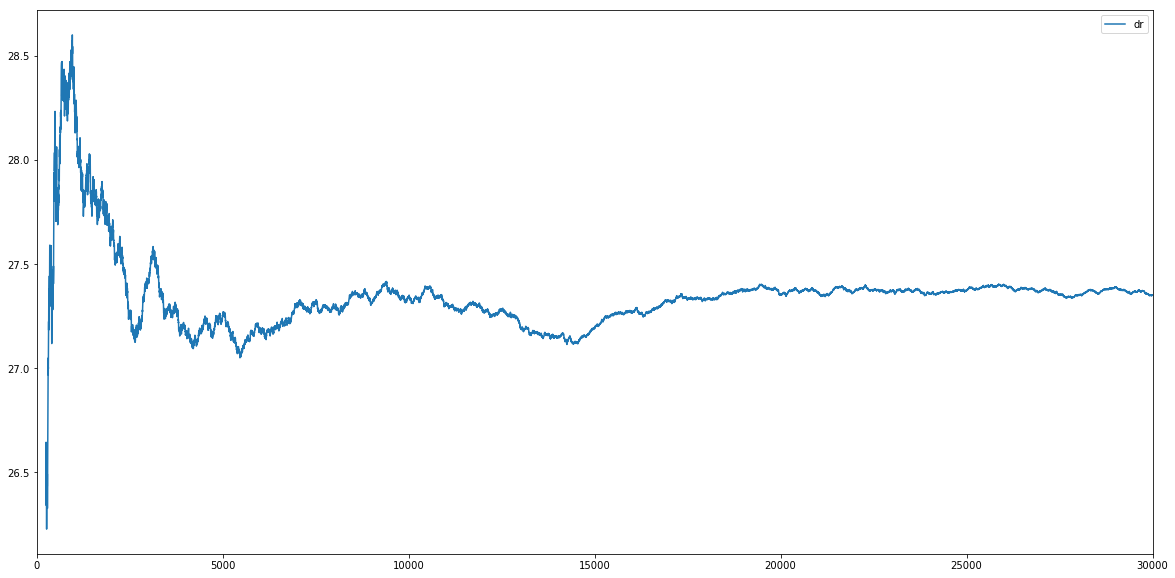

In [10]:
expanding_sharpe_df = daily_df.expanding(252).apply(sharpe_ratio)
expanding_sharpe_df.rename(columns={'dr':'expanding_sharpe'})
expanding_sharpe_df.plot()

## Let's compare both

In [11]:
mu = 0
std = 0
sr = []
for i in range(len(daily)):
    sr_n, mu, std = update_sharpe(mu_prev=mu, std_prev=std, x_n=daily[i], n=i+1, f_s=252)
    sr.append(sr_n)

/home/miguel/anaconda3/envs/cap_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [12]:
len(sr)

30000

In [13]:
expanding_sharpe_df.shape

(30000, 1)

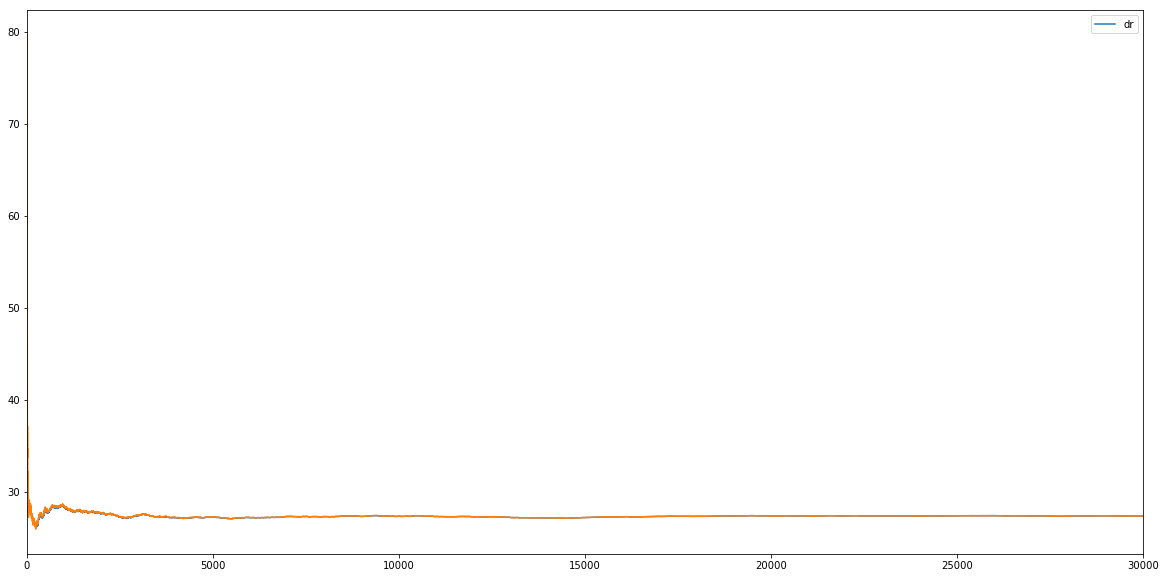

In [14]:
expanding_sharpe_df.plot()
plt.plot(sr)

In [15]:
comp_df = expanding_sharpe_df.copy()
comp_df['sr'] = pd.Series(sr)
comp_df['diff'] = ((comp_df['dr'] - comp_df['sr']) / comp_df['dr']).abs()
comp_df.head()

,dr,sr,diff
0,NaN,inf,NaN
1,NaN,42.361043,NaN
2,NaN,57.186052,NaN
3,NaN,70.509384,NaN
4,NaN,79.678422,NaN


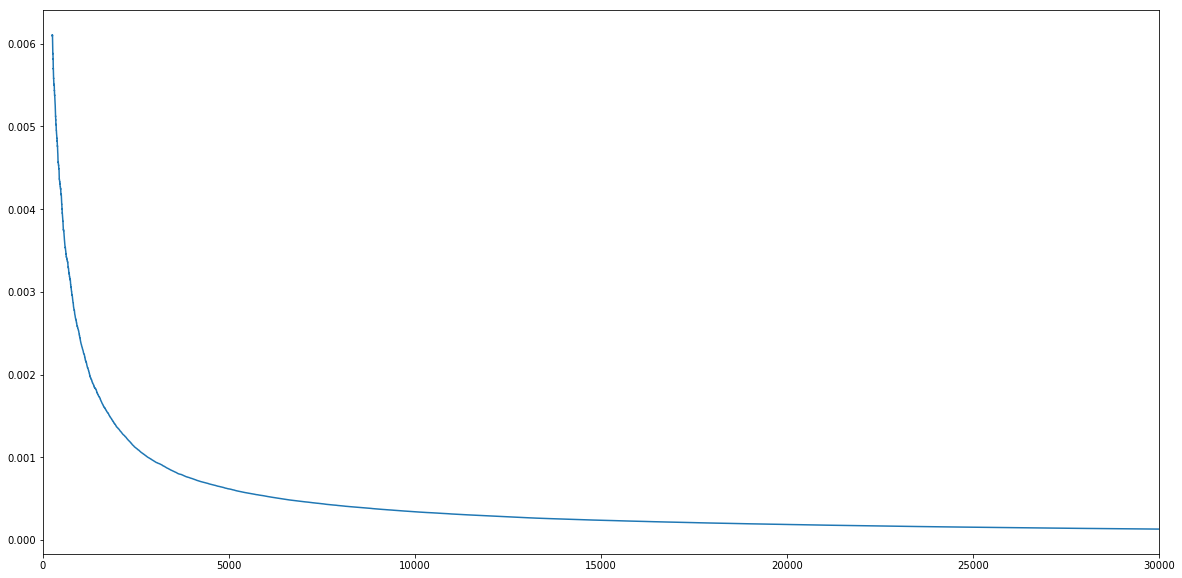

In [16]:
comp_df['diff'].plot()

In [17]:
comp_df['diff'].describe()

count    29749.000000
mean         0.000453
std          0.000650
min          0.000131
25%          0.000168
50%          0.000236
75%          0.000427
max          0.006107
Name: diff, dtype: float64

In [18]:
print('Mean relative error %.2f%%' % (comp_df['diff'].mean() * 100))

Mean relative error 0.05%


In [19]:
comp_df.loc[240:270]

,dr,sr,diff
240,NaN,26.133498,NaN
241,NaN,26.203896,NaN
242,NaN,26.266631,NaN
243,NaN,26.125989,NaN
244,NaN,26.199303,NaN
245,NaN,26.236319,NaN
246,NaN,26.302573,NaN
247,NaN,26.369789,NaN
248,NaN,26.440683,NaN
249,NaN,26.483762,NaN


In [20]:
valid_diff = comp_df.loc[251:, 'diff']

In [21]:
valid_diff.describe()

count    29749.000000
mean         0.000453
std          0.000650
min          0.000131
25%          0.000168
50%          0.000236
75%          0.000427
max          0.006107
Name: diff, dtype: float64

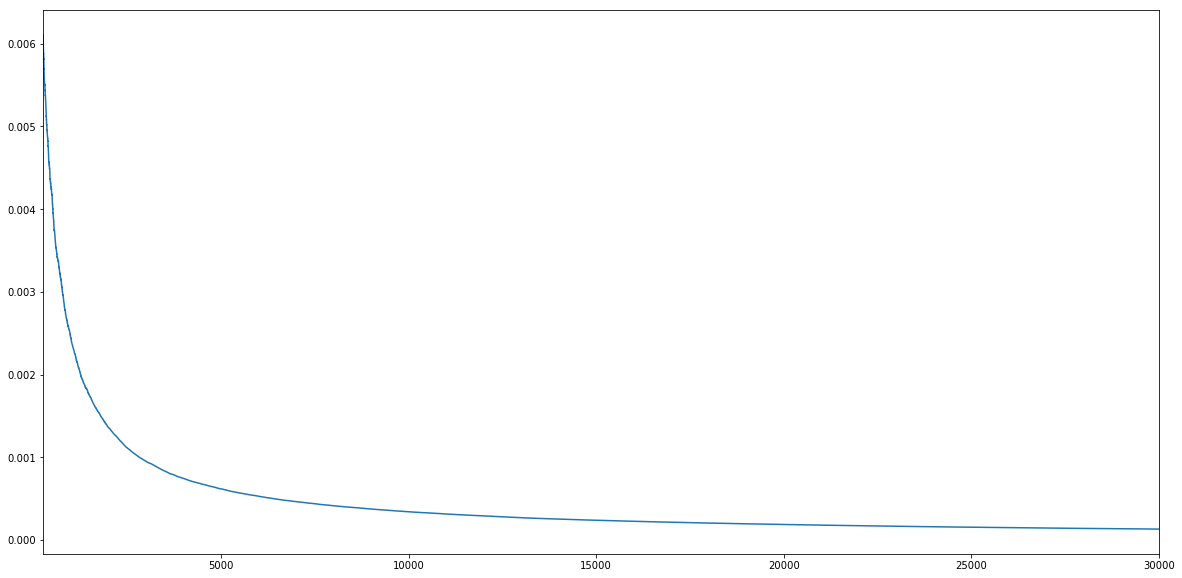

In [22]:
valid_diff.plot()

In [42]:
sr_val = []
for i in range(1,10):
    sr_n = sharpe_ratio(daily[:i], sampling_frequency=252, daily_rfr=0)
    sr_val.append(sr_n)
sr_val

/home/miguel/anaconda3/envs/cap_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


[inf,
 42.361042902072562,
 49.698683383150183,
 58.114222006911135,
 64.801372942475766,
 45.332353689168677,
 48.656641075709679,
 45.123575694588631,
 46.113045516993559]

In [35]:
mu = 0.0
std = 0.0
sr = []
for i in range(10):
    sr_n, mu, std = update_sharpe(mu_prev=mu, std_prev=std, x_n=daily[i], n=i+1, f_s=252.0)
    sr.append(sr_n)
sr

/home/miguel/anaconda3/envs/cap_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


[inf,
 42.361042902072562,
 57.186051951737284,
 70.509383646938986,
 79.678421785114736,
 48.122972028646885,
 52.014394319175715,
 48.084260742838296,
 49.408531378879744,
 45.04157832471666]

In [46]:
mu_n = 0.0
mu = []
for i in range(10):
    mu_n = update_mean(mu_n, daily[i], i+1)
    mu.append(mu_n)
mu

[0.27855465266278201,
 0.44550431289416303,
 0.4313424421933536,
 0.44219056766502229,
 0.45674471700401814,
 0.52513032412954996,
 0.54695934043852479,
 0.51899684754496078,
 0.50805769887570951,
 0.48363294436201237]

In [50]:
mu_val = []
for i in range(10):
    mu_val.append(np.mean(daily[:i+1]))
mu_val

[0.27855465266278201,
 0.44550431289416303,
 0.4313424421933536,
 0.44219056766502229,
 0.45674471700401814,
 0.52513032412954996,
 0.54695934043852479,
 0.51899684754496078,
 0.50805769887570951,
 0.48363294436201237]

In [53]:
(np.array(mu_val) - np.array(mu)).nonzero()

(array([], dtype=int64),)

In [63]:
std_n = 0.0
mu_n = 0.0
std = []
for i in range(10):
    mu_prev = mu_n
    mu_n = update_mean(mu_n, daily[i], i+1)
    std_n = update_std(std_n, mu_prev, daily[i], i+1, mu_n)    
    std.append(std_n)
std

[0.0,
 0.16694966023138103,
 0.13777727146040913,
 0.12078898077661578,
 0.1118895676708517,
 0.18389041783341065,
 0.17844861791579936,
 0.18258348129913038,
 0.1748998758802221,
 0.18138381301018761]

In [64]:
std_val = []
for i in range(10):
    std_val.append(np.std(daily[:i+1], ddof=1))
std_val

/home/miguel/anaconda3/envs/cap_env/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/miguel/anaconda3/envs/cap_env/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[nan,
 0.23610247373279919,
 0.16874200661546282,
 0.13947510113303929,
 0.1250963396425436,
 0.20144185991281854,
 0.19274653678359246,
 0.19518995185879798,
 0.18550933239538578,
 0.19119532659942495]

In [65]:
from utils.running_stats import RunningStats

In [66]:
rstats = RunningStats()

In [67]:
std_val2 = []
for i in range(10):
    rstats.push(daily[i])
    std_val2.append(rstats.standard_deviation())
std_val2

[0.0,
 0.2361024737327992,
 0.16874200661546282,
 0.1394751011330393,
 0.1250963396425436,
 0.20144185991281854,
 0.19274653678359246,
 0.19518995185879798,
 0.18550933239538578,
 0.19119532659942495]